In [1]:
import numpy as np
import os
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf    

2023-06-10 17:40:20.688130: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 17:40:20.740222: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 17:40:20.740836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 17:40:21.450423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class_names = ['0','1','2','3']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (128, 128)

In [3]:

## Function definition
def load_data():
    
    datasets = ['/home/sky/Desktop/driver_drowsiness/dataset/train', '/home/sky/Desktop/driver_drowsiness/dataset/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            curr_label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset, folder)):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                curr_img = cv2.imread(img_path)
                curr_img = cv2.resize(curr_img, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(curr_img)
                labels.append(curr_label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

## Function Call
(train_images, train_labels), (test_images, test_labels) = load_data()


Loading /home/sky/Desktop/driver_drowsiness/dataset/train
Loading /home/sky/Desktop/driver_drowsiness/dataset/test


In [4]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

train_images, train_labels = shuffle(train_images, train_labels)

In [5]:
train_images.shape

(2467, 150, 150, 3)

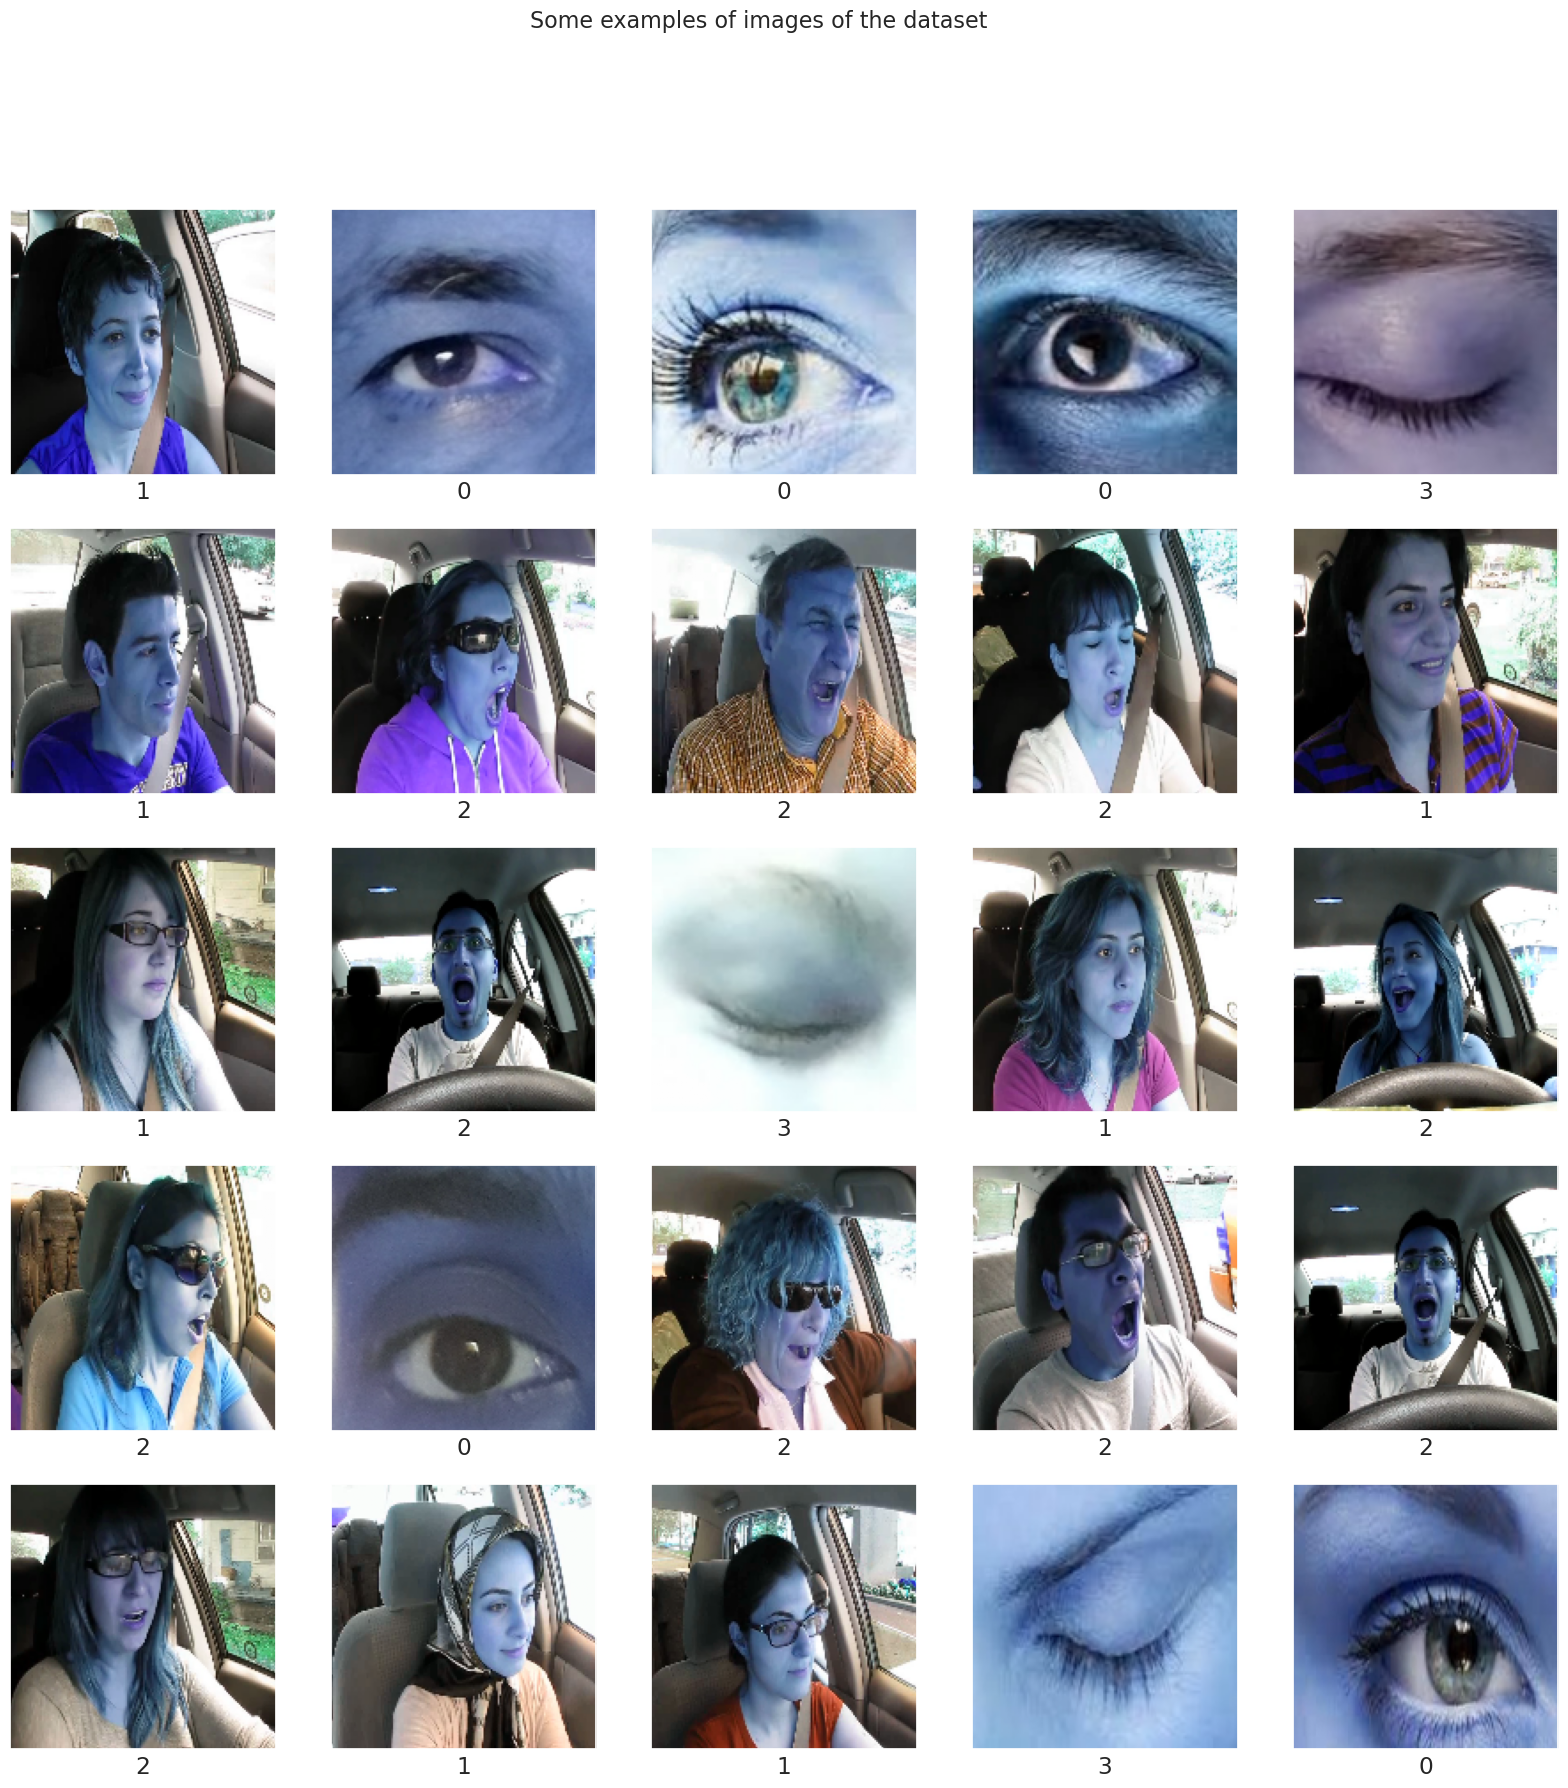

In [8]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.show()

    ## Function call
display_examples(class_names, train_images, train_labels)


In [7]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(train_labels, 4)
y_test = np_utils.to_categorical(test_labels, 4)

In [15]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
input_shape = (128, 128, 3)
nclass = 4

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(128, 128,3))
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, 
                                       momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


In [16]:
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(train_gen.flow(train_images, y_train, batch_size=32),
                              steps_per_epoch=len(train_images) / 64, epochs=10,
                              validation_data = (test_images, y_test))

Epoch 1/10


/tmp/ipykernel_80342/1831491417.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen.flow(train_images, y_train, batch_size=32),
2023-06-10 17:44:46.451591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


38/38 [==============================] - 26s 625ms/step - loss: 2.1635 - accuracy: 0.3397 - val_loss: 0.9339 - val_accuracy: 0.6259
Epoch 2/10
38/38 [==============================] - 23s 608ms/step - loss: 1.5251 - accuracy: 0.4679 - val_loss: 0.6786 - val_accuracy: 0.7090
Epoch 3/10
38/38 [==============================] - 24s 628ms/step - loss: 1.1933 - accuracy: 0.6090 - val_loss: 0.6446 - val_accuracy: 0.7598
Epoch 4/10
38/38 [==============================] - 26s 665ms/step - loss: 1.0150 - accuracy: 0.6506 - val_loss: 0.5519 - val_accuracy: 0.7737
Epoch 5/10
38/38 [==============================] - 26s 670ms/step - loss: 0.9442 - accuracy: 0.6731 - val_loss: 0.5196 - val_accuracy: 0.7691
Epoch 6/10
38/38 [==============================] - 26s 677ms/step - loss: 0.8248 - accuracy: 0.7006 - val_loss: 0.5660 - val_accuracy: 0.7575
Epoch 7/10
38/38 [==============================] - 27s 689ms/step - loss: 0.8472 - accuracy: 0.6891 - val_loss: 0.4767 - val_accuracy: 0.7760
Epoch 8/10

In [ ]:
#model.save("/inception.h5")